In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import cv2 

%matplotlib inline
import matplotlib.pyplot as plt

import os
import math
from utils.dataloaders import full_buildings_loader

import rasterio

In [3]:
DROPOUT = 0.5

def compute_size(inp_size, kernel_size, stride, padding):
    return (inp_size - kernel_size + 2 * padding) / stride + 1

class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out):
        super().__init__()
        self.filters_in = filters_in
        self.filters_out = filters_out
        
        self.conv1 = nn.Conv2d(filters_in, filters_out, (3, 3), padding=1)
        self.norm1 = nn.BatchNorm2d(filters_out)
        self.conv2 = nn.Conv2d(filters_out, filters_out, (3, 3), padding=1)
        self.norm2 = nn.BatchNorm2d(filters_out)

        self.activation = nn.ReLU()

    def forward(self, x):
        conved1 = self.conv1(x)
        conved1 = self.activation(conved1)
        conved1 = self.norm1(conved1)
        conved2 = self.conv2(conved1)
        conved2 = self.activation(conved2)
        conved2 = self.norm2(conved2)
        return conved2

class UNetDownBlock(UNetBlock):
    def __init__(self, input_size, filters_in, filters_out, pooling=True):
        super().__init__(filters_in, filters_out)
        self.filters_out = filters_out
        self.input_size = input_size
        self.pooling = pooling
        
        if pooling:
            self.pool = nn.MaxPool2d(2)
            self.recurrent_weights = nn.Parameter(torch.Tensor(filters_out, input_size//2, input_size//2))
            self.recurrent_activation = nn.Tanh()
        else:
            self.pool = lambda x: x
            self.recurrent_weights = nn.Parameter(torch.Tensor(filters_out, input_size, input_size))
            self.recurrent_activation = nn.Tanh()

    def forward(self, xinp):
        if self.pooling:
            h = torch.randn(xinp.size()[1], self.filters_out, self.input_size//2, self.input_size//2).cuda()
            xout = Variable(torch.zeros(xinp.size()[0], xinp.size()[1], self.filters_out, self.input_size//2, self.input_size//2)).cuda()
        else:
            h = torch.randn(xinp.size()[1], self.filters_out, self.input_size, self.input_size).cuda()
            xout = Variable(torch.zeros(xinp.size()[0], xinp.size()[1], self.filters_out, self.input_size, self.input_size)).cuda()
            
        for i in range(xinp.size()[0]):
            xs = self.pool(super().forward(xinp[i]))
            xs = self.recurrent_activation(self.recurrent_weights * h + xs)
            xout[i] = xs
            
        return xs, xout

class UNetUpBlock(UNetBlock):
    def __init__(self, filters_in, filters_out):
        super().__init__(filters_in, filters_out)
        self.upconv = nn.Conv2d(filters_in, filters_in // 2, (3, 3), padding=1)
        self.upnorm = nn.BatchNorm2d(filters_in // 2)

    def forward(self, x, cross_x):
        x = F.upsample(x, size=cross_x.size()[-2:], mode='bilinear')
        x = self.upnorm(self.activation(self.upconv(x)))
        x = torch.cat((x, cross_x), 1)
        return super().forward(x)

class UNet(nn.Module):
    def __init__(self, input_size, layers, init_filters):
        super().__init__()
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()
        self.input_size = input_size
        self.init_filters = init_filters

        
        self.data_norm = nn.BatchNorm2d(4)
        self.init_layer = nn.Conv2d(4, init_filters, (7, 7), padding=(3,3))
        self.activation = nn.ReLU()
        self.init_norm = nn.BatchNorm2d(init_filters)
        self.dropout = nn.Dropout(DROPOUT)
        
        self.recurrent_weights = nn.Parameter(torch.Tensor(init_filters, input_size, input_size))
        self.recurrent_activation = nn.Tanh()
        
        filter_size = init_filters
        for i in range(layers - 1):
            self.down_layers.append(
                UNetDownBlock(input_size, filter_size, filter_size * 2)
            )
            filter_size *= 2
            input_size = input_size // 2
        self.down_layers.append(UNetDownBlock(input_size, filter_size, filter_size * 2, pooling=False))
        for i in range(layers):
            self.up_layers.append(
                UNetUpBlock(filter_size * 2, filter_size)
            )
            filter_size //= 2

    def forward(self, xinp):
        h = torch.randn(xinp.size()[1], self.init_filters, self.input_size, self.input_size).cuda()
        xout = Variable(torch.zeros(xinp.size()[0], xinp.size()[1], self.init_filters, self.input_size, self.input_size)).cuda()
        
        for i in range(xinp.size()[0]):
            xs = self.data_norm(xinp[i])
            xs = self.init_norm(self.activation(self.init_layer(xs)))
            xs = self.recurrent_activation(self.recurrent_weights * h + xs)
            xout[i] = xs
            
        saved_x = [xs]
        for layer in self.down_layers:
            saved_x.append(xs)
            xs, xout = layer(xout)
            xs = self.dropout(xs)
        is_first = True
        for layer, saved_x in zip(self.up_layers, reversed(saved_x)):
            if not is_first:
                is_first = False
                xs = self.dropout(xs)
            xs = layer(xs, saved_x)
        return xs

class UNetClassify(UNet):
    def __init__(self, *args, **kwargs):
        init_val = kwargs.pop('init_val', 0.5)
        super().__init__(*args, **kwargs)
        self.output_layer = nn.Conv2d(self.init_filters, 1, (3, 3), padding=1)

        for name, param in self.named_parameters():
            typ = name.split('.')[-1]
            if typ == 'bias':
                if 'output_layer' in name:
                    # Init so that the average will end up being init_val
                    param.data.fill_(-math.log((1-init_val)/init_val))
                else:
                    param.data.zero_()

    def forward(self, x):
        x = super().forward(x)
        # Note that we don't perform the sigmoid here.
        return self.output_layer(x)

In [20]:
# model = torch.load('../weights/onera/3dconv_seg.pt')
model = UNetClassify(input_size=64, layers=4, init_filters=32, init_val=0.5).cuda()
weights = torch.load('../weights/buildings_change/unet3d_4band_5dates_dice.pt')
model.load_state_dict(weights)
model.eval()

UNetClassify(
  (down_layers): ModuleList(
    (0): UNetDownBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (recurrent_activation): Tanh()
    )
    (1): UNetDownBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): 

In [21]:
dataset = full_buildings_loader('../datasets/buildings_change/')

(4, 5, 6794, 7884) (6794, 7884)


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


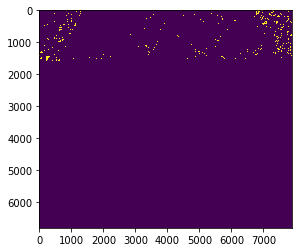

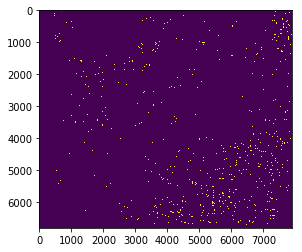

In [34]:
# img = np.transpose(np.asarray([dataset['images']]), (2,0,1,3,4))
label = dataset['labels']
out = np.zeros((img.shape[3],img.shape[4]))
count = 0
for i in range(0,img.shape[3],64):
    for j in range(0,img.shape[4],64):
        if i + 64 < img.shape[3] and j + 64 < img.shape[4]:
            patch = torch.from_numpy(img[:,:,:,i:i+64, j:j+64]).cuda()
            logits = model(patch)
#                 print (logits.min(),logits.max())
            pred = F.sigmoid(logits)
#             print (pred.max(), pred.min())
            pred = pred > 0.1
#             print (pred.size())
            pred = pred.data.cpu().numpy()[0][0]
            out[i:i+64,j:j+64] = pred
            count += 1
            if count == 3000:
                break
    if count == 3000:
        break
plt.imshow(out)
plt.show()
plt.imshow(label)
plt.show()

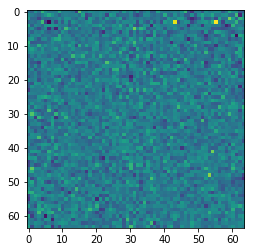

In [29]:

plt.imshow(model.state_dict()['recurrent_weights'].data.cpu().numpy()[0])

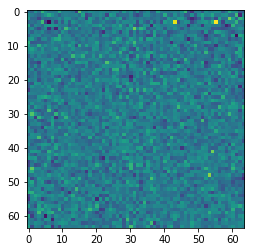

In [30]:
plt.imshow(weights['recurrent_weights'].data.cpu().numpy()[0])

In [10]:
weights.keys()

odict_keys(['recurrent_weights', 'down_layers.0.recurrent_weights', 'down_layers.0.conv1.weight', 'down_layers.0.conv1.bias', 'down_layers.0.norm1.weight', 'down_layers.0.norm1.bias', 'down_layers.0.norm1.running_mean', 'down_layers.0.norm1.running_var', 'down_layers.0.norm1.num_batches_tracked', 'down_layers.0.conv2.weight', 'down_layers.0.conv2.bias', 'down_layers.0.norm2.weight', 'down_layers.0.norm2.bias', 'down_layers.0.norm2.running_mean', 'down_layers.0.norm2.running_var', 'down_layers.0.norm2.num_batches_tracked', 'down_layers.1.recurrent_weights', 'down_layers.1.conv1.weight', 'down_layers.1.conv1.bias', 'down_layers.1.norm1.weight', 'down_layers.1.norm1.bias', 'down_layers.1.norm1.running_mean', 'down_layers.1.norm1.running_var', 'down_layers.1.norm1.num_batches_tracked', 'down_layers.1.conv2.weight', 'down_layers.1.conv2.bias', 'down_layers.1.norm2.weight', 'down_layers.1.norm2.bias', 'down_layers.1.norm2.running_mean', 'down_layers.1.norm2.running_var', 'down_layers.1.norm2